## Generate a PSD plot framework for future plots (this one is based on our first buoy experiment).

In [1]:
#Purisa Jasmine Simmons
#August 2018

#Overview: PSD for E3 (Buoy_Calibrator1), trying to generate a PSD plot (framework for future plots).
#Based on Method V of this paper: https://journals.ametsoc.org/doi/pdf/10.1175/2010JTECHO724.1

#First, parse the data from the .CSV file.
#This data comes from a controlled experiment (CE3), so we are assuming that 
#all of the vertical accelerations are contained in IMUA2.

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz

import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

import mpld3
import folium
import cmocean
import skinematics as skin
from skinematics import quat, vector, misc, rotmat, imus, view
import pygame

from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added

# For the definition of the abstract base class IMU_Base
import abc

import sys

# %matplotlib notebook
%matplotlib inline


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
ride_ids = ['14888']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)

In [3]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            print(ocean_df_small)
            
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
    



In [4]:
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.
#print(motion_df)


https://surf.smartfin.org/ride/14888
https://surf.smartfin.org/media/201807/google_117589279598321562176_000666D321BE_180730171718_Ocean.CSV
                               Time  Temperature 1  Calibrated Temperature 1  \
UTC                                                                            
2018-07-30 17:17:23.862  2067196127            463                    28.938   
2018-07-30 17:17:29.902  2067202149            464                    29.000   
2018-07-30 17:17:35.940  2067208169            464                    29.000   
2018-07-30 17:17:41.979  2067214190            464                    29.000   
2018-07-30 17:17:48.018  2067220212            464                    29.000   
2018-07-30 17:17:54.055  2067226231            464                    29.000   
2018-07-30 17:18:00.093  2067232251            464                    29.000   
2018-07-30 17:18:06.131  2067238271            464                    29.000   
2018-07-30 17:18:12.169  2067244291            464         

Ride data has been uploaded.


## Make a copy of the original motion_df dataframe

In [5]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data

print(saved_copy_motion_df)

                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
14888   2018-07-30 17:17:24.303  2.067197e+09   -34.0  -520.0   -48.0    82.0   
        2018-07-30 17:17:24.336  2.067197e+09   -30.0  -517.0   -57.0    32.0   
        2018-07-30 17:17:24.369  2.067197e+09   -28.0  -517.0   -59.0    -7.0   
        2018-07-30 17:17:24.402  2.067197e+09   -28.0  -518.0   -62.0   -27.0   
        2018-07-30 17:17:24.435  2.067197e+09   -30.0  -517.0   -62.0    64.0   
        2018-07-30 17:17:24.468  2.067197e+09   -31.0  -518.0   -54.0   157.0   
        2018-07-30 17:17:24.501  2.067197e+09   -33.0  -520.0   -41.0    29.0   
        2018-07-30 17:17:24.534  2.067197e+09   -30.0  -519.0   -46.0  -101.0   
        2018-07-30 17:17:24.567  2.067197e+09   -30.0  -517.0   -55.0  -121.0   
        2018-07-30 17:17:24.600  2.067197e+09   -29.0  -517.0   -63.0   -26.0   
        2018-07-30 17:17:24.

## Calcualting time_elapseds, time_offsets and creating IMU1, IMU2, and IMU3 raw data lists

In [13]:
#Reading data from ride_ids = ['xxxxx']
#The name of the motion dataframe is: motion_df

#Get times from the "Time" column to create time_o_list and time_e_list.
#Get imus from the "IMU A[*]" column to create the imu acc arrays. 

#Drop the "nan" values from the columns that we care about. 
dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3'])

#Can test that this works by printing this one:
#dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'Latitude'])
#print(dropped_df)

time_e_list = []
time_o_list = []

#Remove all nan instances in time:
time_array_nans = np.array(dropped_motion_df.loc[:,"Time"], dtype=float)
time_array = []

imu1_array_nans = np.array(dropped_motion_df.loc[:,"IMU A1"], dtype=float)
imu_array1 = []

imu2_array_nans = np.array(dropped_motion_df.loc[:,"IMU A2"], dtype=float)
imu_array2 = []

imu3_array_nans = np.array(dropped_motion_df.loc[:,"IMU A3"], dtype=float)
imu_array3 = []


#Get all the times and imus where time, imu1, imu2, and imu3 are NOT nan values:
for t,x,y,z in zip(time_array_nans, imu1_array_nans, imu2_array_nans, imu3_array_nans):
    if (np.isnan(t)==0 and np.isnan(x)==0 and np.isnan(y)==0 and np.isnan(z)==0):
        time_array.append(t)
        imu_array1.append(x)
        imu_array2.append(y)
        imu_array3.append(z)

#for x in time_array:
#    print(x)
    
start_time = time_array[0]
time_len = len(time_array)
    
i = 0
while (i < time_len - 1):
    prev = time_array[i]
    after = time_array[i+1]
    
    #print(prev, " ", after)
    #print(after - prev)
    
    offset = after - prev
    #if (np.isnan(offset)==0):
    time_o_list.append(offset)
    
    elapsed = time_array[i] - start_time
    #if (np.isnan(elapsed)==0):
    time_e_list.append(elapsed)
    
    i = i + 1


##Check to make sure there are no "nan" values:
i = 0
while (i < len(time_o_list)):
    if (np.isnan(time_o_list[i])):
        print("Error! Value at index: ", i, " is nan")
    i = i + 1

#Drop the last value from each of the imu lists to make it match the time list.
del(imu_array1[-1])
del(imu_array2[-1])
del(imu_array3[-1])
    
print(len(time_e_list))
print(len(time_o_list))
print(len(imu_array1))
print(len(imu_array2))
print(len(imu_array3))





7437
7437
7437
7437
7437


## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])

7437
7437
7437
Graph of our entire experiment:


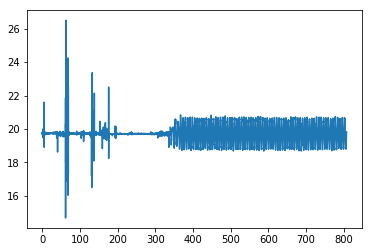

In [14]:
## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])


#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512

#Approximate measurement for gravity:
gravity = -9.80665


# Correct the IMU Acceleration columns into units of meters
# Dividing by 512 is equivalent to muliplying by 4 to correct the bit shifting by 2 places and dividing by 2048 to convert bits to G's
# Multiplying by the 9.81 afterwards is simply to convert G's into m/s^2

def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??)
        new_a = a / g_const * gravity - gravity
        ret_array.append(new_a)
    return ret_array

imu1_array = convert_acc_units(imu_array1) #new units in m/s^2
imu2_array = convert_acc_units(imu_array2) #new units in m/s^2
imu3_array = convert_acc_units(imu_array3) #new units in m/s^2

##To check:
#for x,y in zip(imu2_array, imu_array2):
#    print(x,y)
    
    
def convert_time_units(time_array):
    ret_array = []
    for t in time_array:
        new_t = t * (10**(-3)) #converting units in milliseconds to seconds
        ret_array.append(new_t)
    return ret_array

time_o_array = convert_time_units(time_o_list) #new units in seconds
time_e_array = convert_time_units(time_e_list) #new units in seconds

##To check:
#for t in time_e_array:
#    print(t)

print(len(time_e_array))
print(len(time_e_list))
print(len(imu2_array))

print("Graph of our entire experiment:")

plt.plot(time_e_array, imu2_array)
#plt.ylim(-1,1)
plt.show()

#print("Why are the y-axis values so small?")

## PSD Step 1: Seperate each of the subexperiments into its own acc lists

In [15]:
#for x in time_e_array:
#    print(x)

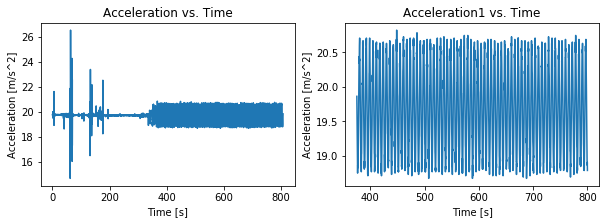

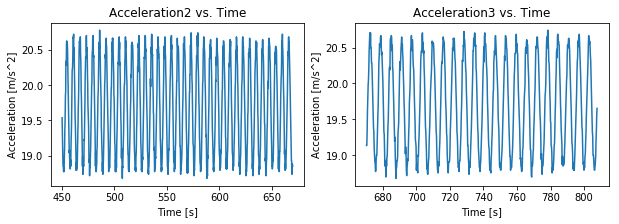

In [27]:
#Seperate each of the subexperiments into its own acc lists.
#i.e. subexperiment1 corresponds to acc1, (subexperiment2 => acc2), etc.

time_e_list1 = []
time_e_list2 = []
time_e_list3 = []

acc_list = []
acc_list1 = []
acc_list2 = []
acc_list3 = []

time_array = []
acc_array = []

gravity = -9.80665

#For our controlled experiments, we know that imu2 is the vertical axis
acc_list = imu2_array
time_array = time_e_array


#i = 0
#while (i < len(imu2_array)):
#    imu2_array[i] = imu2_array[i] - gravity
#    i = i + 1
#print(imu2_array)

i = 0
while (i < (len(acc_list)) - 1):
    if (time_e_array[i] > 375 and time_e_array[i] <= 800):
        acc_list1.append(acc_list[i])
        time_e_list1.append(time_e_array[i])
    if (time_e_array[i] > 450 and time_e_array[i] <= 670):
        acc_list2.append(acc_list[i])
        time_e_list2.append(time_e_array[i])
    if (time_e_array[i] > 670 and time_e_array[i] <= 850):
        acc_list3.append(acc_list[i])
        time_e_list3.append(time_e_array[i])
    i = i + 1
    
#Plot the subexperiments to verify correctness:
acc_array = np.array(acc_list)   #acc_list gets vertical acceleration from y-axis imu2


time_array1 = np.array(time_e_list1)
acc_array1 = np.array(acc_list1)
time_array2 = np.array(time_e_list2)
acc_array2 = np.array(acc_list2)
time_array3 = np.array(time_e_list3)
acc_array3 = np.array(acc_list3)
  
    
##Plotting:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

ax1.plot(time_array, acc_array)
ax1.set_title("Acceleration vs. Time")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')

ax2.plot(time_array1, acc_array1)
ax2.set_title("Acceleration1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Acceleration [m/s^2]")
#ax2.set_ylim([-6,6])

ax3.plot(time_array2, acc_array2)
ax3.set_title("Acceleration2 vs. Time")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Acceleration [m/s^2]")
#ax3.set_ylim([-6,6])

ax4.plot(time_array3, acc_array3)
ax4.set_title("Acceleration3 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Acceleration [m/s^2]")
#ax4.set_ylim([-6,6])

plt.show()
    

## PSD Step 2: Detrend the data 

In [28]:
##PSD Step 2: Detrend the data 
dacc_array1 = signal.detrend(acc_array1)
dacc_array2 = signal.detrend(acc_array2)
dacc_array3 = signal.detrend(acc_array3)

##Remove outliers--points greater than 3x the standard deviation
std1 = np.std(dacc_array1)*3
std2 = np.std(dacc_array2)*3
std3 = np.std(dacc_array3)*3

#Returns a new array that is the same as the array passed in, with its outliers removed.
def removed_outliers(a_array, time_array, std):
    i = 0
    count = 0
    ret_accs = []
    ret_times = []
    while i < (len(a_array)):
        #if smaller than std, keep that value (larger ones get removed)
        if abs(a_array[i]) < std:
            ret_accs.append(a_array[i])
            ret_times.append(time_array[i])
        else:
            count = count + 1  #could help with debugging to know how many outliers removed
        i = i + 1  
    return count, ret_accs, ret_times;
        
count1, ro_array1, ro_time1 = removed_outliers(dacc_array1, time_array1, std1)
count2, ro_array2, ro_time2 = removed_outliers(dacc_array2, time_array2, std2)
count3, ro_array3, ro_time3 = removed_outliers(dacc_array3, time_array3, std3)

#print(len(dacc_array1))
#print(count1)
#print(len(ro_array1))

##Set up data interpolation (using Cubic Splines) for use in next step
cs1 = CubicSpline(ro_time1, ro_array1)
cs2 = CubicSpline(ro_time2, ro_array2)
cs3 = CubicSpline(ro_time3, ro_array3)


##interpld returns a function that relates y=ro_array (without outliers) to x=time:
#cs1 = interp1d(ro_time1, ro_array1)
#cs2 = interp1d(ro_time2, ro_array2)
#cs3 = interp1d(ro_time3, ro_array3)

#Now, use this interpolation to put points back into the original graph:
def add_interpolated_pts(a_array, time_array, std, cs):
    i = 0
    ret_acc = []
    while i < (len(a_array)):
        if abs(a_array[i]) > std:
            ret_acc.append(cs(time_array[i]))
        else:
            ret_acc.append(a_array[i])
        i = i + 1  
    return ret_acc;


#These are the new arrays with the interpolated points (which we will
#feed into a Kalman filter later).
interp_array1 = add_interpolated_pts(dacc_array1, time_array1, std1, cs1)
interp_array2 = add_interpolated_pts(dacc_array2, time_array2, std2, cs2)
interp_array3 = add_interpolated_pts(dacc_array3, time_array3, std3, cs3)


#print(len(interp_array1))
#print(len(dacc_array1))

##To verify that the two arrays are different(i.e. pts were actually interpolated):
j = 0
count = 0
while (j < (len(interp_array1) - 1)):
    if interp_array1[j] != dacc_array1[j]:
        count = count + 1
    j = j + 1
        
#print(count)
    

## Plot all of the data, to see visually:

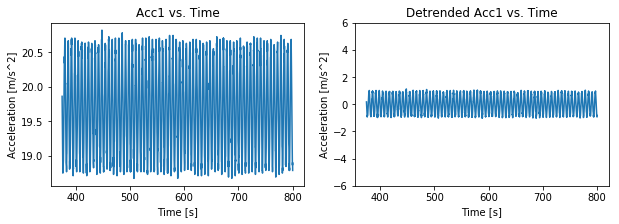

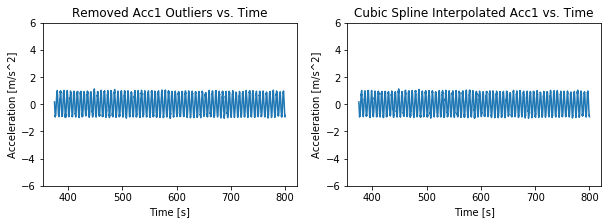

In [29]:
##Plotting the results for the 1st sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

ax1.plot(time_array1, acc_array1)
ax1.set_title('Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
#ax1.set_ylim([-6,6])

ax2.plot(time_array1, dacc_array1)
ax2.set_title("Detrended Acc1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

ax3.plot(ro_time1, ro_array1)
ax3.set_title('Removed Acc1 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])

ax4.plot(time_array1, interp_array1)
ax4.set_title("Cubic Spline Interpolated Acc1 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()

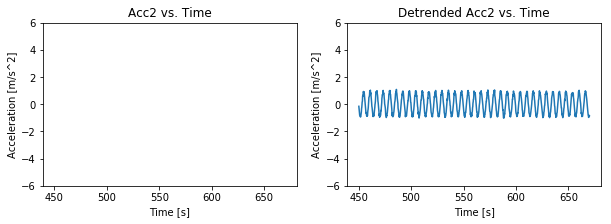

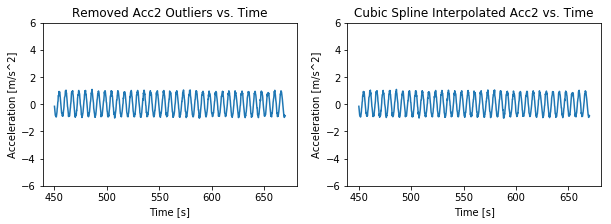

In [30]:
##Plotting the results for the 2nd sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)


##Subplots for acc2
ax1.plot(time_array2, acc_array2)
ax1.set_title('Acc2 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_ylim([-6,6])
ax2.plot(time_array2, dacc_array2)
ax2.set_title("Detrended Acc2 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

##Subplots for acc3
ax3.plot(ro_time2, ro_array2)
ax3.set_title('Removed Acc2 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])
ax4.plot(time_array2, interp_array2)
ax4.set_title("Cubic Spline Interpolated Acc2 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()




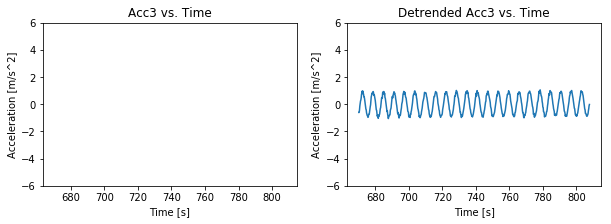

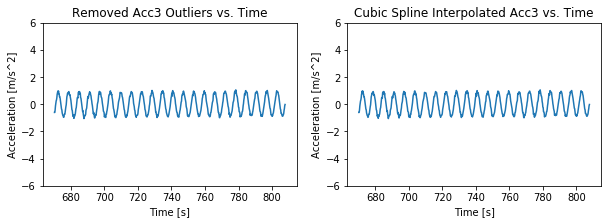

In [31]:
##Plotting the results for the 3rd sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)


##Subplots for acc2
ax1.plot(time_array3, acc_array3)
ax1.set_title('Acc3 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_ylim([-6,6])
ax2.plot(time_array3, dacc_array3)
ax2.set_title("Detrended Acc3 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

##Subplots for acc3
ax3.plot(ro_time3, ro_array3)
ax3.set_title('Removed Acc3 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])
ax4.plot(time_array3, interp_array3)
ax4.set_title("Cubic Spline Interpolated Acc3 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()



Here, I'm implementing a lowess filter instead of a Kalman 
 filter right now because it seems simpler to implement.




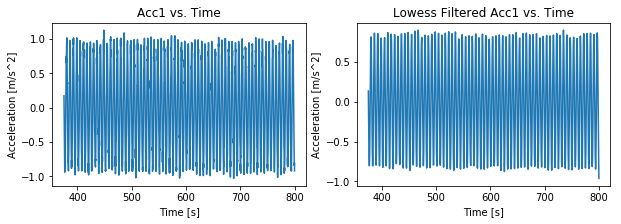

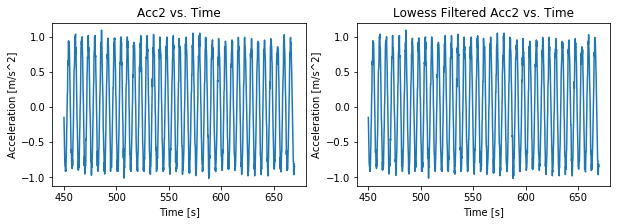

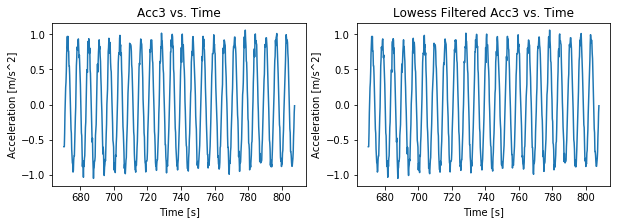

Comments: Here, I'm not sure if the Lowess filtered version of Acc3 is better 
 than the original.


In [32]:
##Now, feed interpolated arrays through a Kalman filter:
##(Actually I'm going to use a LOWESS filter for simplicity)

print("\n")
print("Here, I'm implementing a lowess filter instead of a Kalman \n filter right now because it seems simpler to implement.")
print("\n")

lowess = sm.nonparametric.lowess

#Parameters: takes in (y,x, ...)
filtered1 = lowess(interp_array1, time_array1, frac=0.005, is_sorted=True, return_sorted=False) 
filtered2 = lowess(interp_array2, time_array2, frac=0.002, is_sorted=True, return_sorted=False) 
filtered3 = lowess(interp_array3, time_array3, frac=0.002, is_sorted=True, return_sorted=False) 


##Plotting the filtered results:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

f3 = plt.figure(figsize=(10,3))
ax5 = f3.add_subplot(121)
ax6 = f3.add_subplot(122)


##Subplots for acc1
ax1.plot(time_array1, interp_array1)
ax1.set_title('Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax2.plot(time_array1, filtered1)
ax2.set_title("Lowess Filtered Acc1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')

##Subplots for acc2
ax3.plot(time_array2, interp_array2)
ax3.set_title('Acc2 vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax4.plot(time_array2, filtered2)
ax4.set_title("Lowess Filtered Acc2 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')

##Subplots for acc3
ax5.plot(time_array3, interp_array3)
ax5.set_title('Acc3 vs. Time')
ax5.set_xlabel("Time [s]")
ax5.set_ylabel('Acceleration [m/s^2]')
ax6.plot(time_array3, filtered3)
ax6.set_title("Lowess Filtered Acc3 vs. Time")
ax6.set_xlabel("Time [s]")
ax6.set_ylabel('Acceleration [m/s^2]')

plt.show()

print("Comments: Here, I'm not sure if the Lowess filtered version of Acc3 is better \n than the original.")


## PSD Step 3: FFT of filtered data

0.26428726211
Experiment Explanations:
Experiment1: We created 'waves' with amplitude of 1m and period of 6s.
We expect to see a peak at: 1/6s = 0.16 Hz.
Experiment2: We created 'waves' with amplitude 1.5m and period = 4s.
We expect to see a peak at: 1/4s = 0.25 Hz.
Experiment3: We created 'waves' with amplitude of 1m and period of 2s.
We expect to see a peak at: 1/2s = 0.5. Hz.


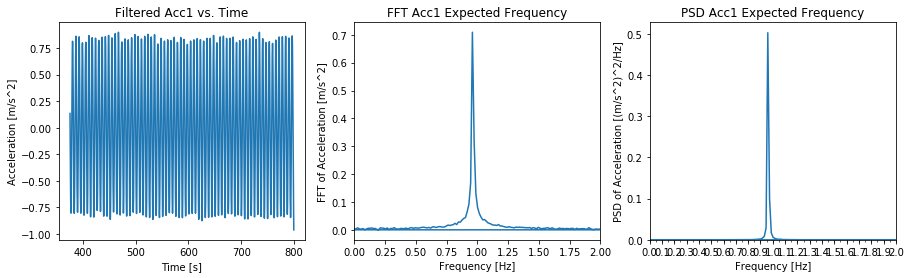

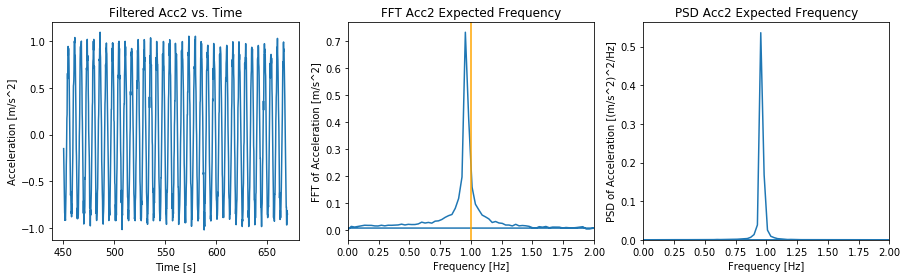

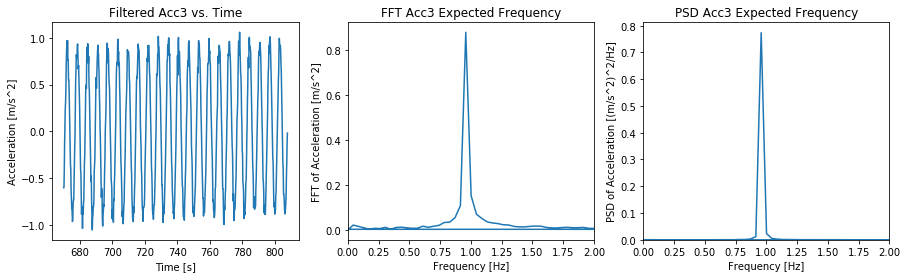

In [60]:
#First, need to fit the data so that the timestamps are *exactly* uniform

##PSD of filtered data
#psd1 = scipy.signal.periodogram(filtered1)
#psd2 = scipy.signal.periodogram(filtered2)
#psd3 = scipy.signal.periodogram(filtered3)

#These are just in case we have diff. rates later
#sampling_rate = 30
#inverse_sampling_rate = 1./sampling_rate
#timestep = inverse_sampling_rate

sum = 0
for f in filtered1:
    if f > 0:
        sum = sum + f
sum = sum/len(filtered1)
print(sum)

#For the 30Hz data we will just use timestep = 0.033
sampling_freq = 30
timestep = 1/sampling_freq

fft1 = abs(np.fft.fft(filtered1))
fft2 = abs(np.fft.fft(filtered2))
fft3 = abs(np.fft.fft(filtered3))

#n1 = filtered1.size
#n2 = filtered2.size
#n3 = filtered3.size

n1 = len(fft1)
n2 = len(fft2)
n3 = len(fft3)

fft_freq1 = np.fft.fftfreq(n1, timestep)
fft_freq2 = np.fft.fftfreq(n2, timestep)
fft_freq3 = np.fft.fftfreq(n3, timestep)


#Shifting the frequency signals:
fft_y_shifted1 = np.fft.fftshift(fft1)
freq_shifted1 = np.fft.fftshift(fft_freq1)

fft_y_shifted2 = np.fft.fftshift(fft2)
freq_shifted2 = np.fft.fftshift(fft_freq2)

fft_y_shifted3 = np.fft.fftshift(fft3)
freq_shifted3 = np.fft.fftshift(fft_freq3)


#Normalize the signals (to get correct amplitudes):
#fft_normal1 = np.abs(fft_y_shifted1/n1)*2
#fft_normal2 = np.abs(fft_y_shifted2/n2)*2
#fft_normal3 = np.abs(fft_y_shifted3/n3)*2

fft_normal1 = np.abs(fft1/n1)*2
fft_normal2 = np.abs(fft2/n2)*2
fft_normal3 = np.abs(fft3/n3)*2


#Here, we want to apply a low pass filter, and we only care about lower frequency signals (smaller than a
#frequency of 0.5 or 0.6)

#for x,y in zip(filtered1,fft1):
#    print(x)
#    print(y)

#for x in fft1:
#    print(x)

print("Experiment Explanations:")
print("Experiment1: We created 'waves' with amplitude of 1m and period of 6s.")
print("We expect to see a peak at: 1/6s = 0.16 Hz.")
print("Experiment2: We created 'waves' with amplitude 1.5m and period = 4s.")
print("We expect to see a peak at: 1/4s = 0.25 Hz.")
print("Experiment3: We created 'waves' with amplitude of 1m and period of 2s.")
print("We expect to see a peak at: 1/2s = 0.5. Hz.")

##Calculating PSD graph:
#Can either estimate this by squaring the FFT or by using the python Periodogram function.

#freq1, pxx1 = acc_psd1 = signal.periodogram(filtered1, fs=30, scaling='density')
#freq2, pxx2 = acc_psd2 = signal.periodogram(filtered2, fs=30, scaling='density')
#freq3, pxx3 = acc_psd3 = signal.periodogram(filtered3, fs=30, scaling='density')


#Normalized PSD graphs:
def normalize_psd(fft_normal, fft_freq):
    ret_pxx = fft_normal**2
    ret_freq = fft_freq
    return ret_pxx, ret_freq

pxx1, freq1 = normalize_psd(fft_normal1, fft_freq1)
pxx2, freq2 = normalize_psd(fft_normal2, fft_freq2)
pxx3, freq3 = normalize_psd(fft_normal3, fft_freq3)


#Calculate the peaks:
peak_fft1 = fft_freq1[np.argmax(fft1)]
peak_fft2 = fft_freq2[np.argmax(fft2)]
peak_fft3 = fft_freq3[np.argmax(fft3)]

peak_psd1 = freq1[np.argmax(pxx1)]
peak_psd2 = freq2[np.argmax(pxx2)]
peak_psd3 = freq3[np.argmax(pxx3)]


##Plotting the psd results:
f1 = plt.figure(figsize=(15,4))
ax1 = f1.add_subplot(131)
ax2 = f1.add_subplot(132)
ax7 = f1.add_subplot(133)

f2 = plt.figure(figsize=(15,4))
ax3 = f2.add_subplot(131)
ax4 = f2.add_subplot(132)
ax8 = f2.add_subplot(133)

f3 = plt.figure(figsize=(15,4))
ax5 = f3.add_subplot(131)
ax6 = f3.add_subplot(132)
ax9 = f3.add_subplot(133)

##Subplots for acc1
ax1.plot(time_array1, filtered1)
ax1.set_title('Filtered Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
#------------------------------
ax2.plot(fft_freq1, fft_normal1)
ax2.set_title("FFT Acc1 Expected Frequency")
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel('FFT of Acceleration [m/s^2]')
ax2.set_xlim(0,2)
#ax2.set_ylim(0,)
#ax2.xaxis.set_major_locator(plt.MultipleLocator(0.1))
#ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
#ax2.axvline(0.16, color="orange")
##ax2.axvline(peak_fft1, color="red")
#------------------------------
ax7.plot(freq1, pxx1)
ax7.set_title("PSD Acc1 Expected Frequency")
ax7.set_xlabel("Frequency [Hz]")
ax7.set_ylabel('PSD of Acceleration [(m/s^2)^2/Hz]')
ax7.set_xlim(0,2)
ax7.set_ylim(0,)
ax7.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax7.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
#ax7.axvline(0.16, color="orange")
#ax7.axvline(peak_psd1, color="red")


##Subplots for acc2
ax3.plot(time_array2, filtered2)
ax3.set_title('Filtered Acc2 vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
#--------------------------------------
ax4.plot(fft_freq2, fft_normal2)
ax4.set_title("FFT Acc2 Expected Frequency")
ax4.set_xlabel("Frequency [Hz]")
ax4.set_ylabel('FFT of Acceleration [m/s^2]')
ax4.set_xlim(0,2)
#ax4.set_ylim(0,)
#ax4.xaxis.set_major_locator(plt.MultipleLocator(0.1))
#ax4.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax4.axvline(1.0, color="orange")
#--------------------------------------
ax8.plot(freq2, pxx2)
ax8.set_title("PSD Acc2 Expected Frequency")
ax8.set_xlabel("Frequency [Hz]")
ax8.set_ylabel('PSD of Acceleration [(m/s^2)^2/Hz]')
ax8.set_xlim(0,2)
ax8.set_ylim(0,)
#ax8.xaxis.set_major_locator(plt.MultipleLocator(0.1))
#ax8.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
#ax8.axvline(0.25, color="orange")

##Subplots for acc3
ax5.plot(time_array3, filtered3)
ax5.set_title('Filtered Acc3 vs. Time')
ax5.set_xlabel("Time [s]")
ax5.set_ylabel('Acceleration [m/s^2]')
#--------------------------------------
ax6.plot(fft_freq3, fft_normal3)
ax6.set_title("FFT Acc3 Expected Frequency")
ax6.set_xlabel("Frequency [Hz]")
ax6.set_ylabel('FFT of Acceleration [m/s^2]')
ax6.set_xlim(0,2)
#ax6.set_ylim(0,)
#ax6.xaxis.set_major_locator(plt.MultipleLocator(0.1))
#ax6.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
#ax6.axvline(0.5, color="orange")
#--------------------------------------
ax9.plot(freq3, pxx3)
ax9.set_title("PSD Acc3 Expected Frequency")
ax9.set_xlabel("Frequency [Hz]")
ax9.set_ylabel('PSD of Acceleration [(m/s^2)^2/Hz]')
ax9.set_xlim(0,2)
ax9.set_ylim(0,)
#ax9.xaxis.set_major_locator(plt.MultipleLocator(0.1))
#ax9.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
#ax9.axvline(0.5, color="orange")


plt.show()



#KaiserBessel window (based on the modified zero-order Bessel function) to reduce
#spectral leakage.

In [50]:
#Next steps: Noise-correct acceleration spectra
#1. Kaiser Bessel Window before FFT, and then post-processing of data
#2. Frequency Domain Filter to acceleration spectra to remove low-frequency noise
#   (modification of empirical noise correction of Lang 1987)





## Displacement Spectra:

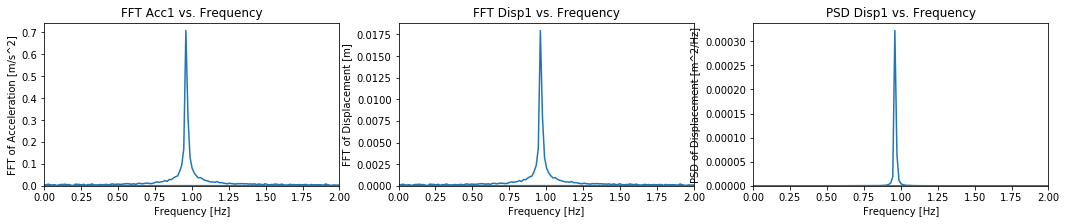

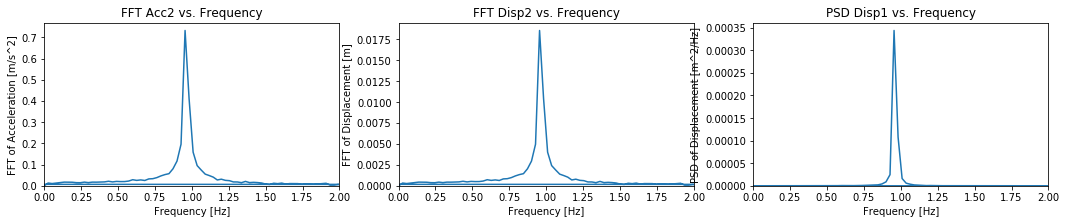

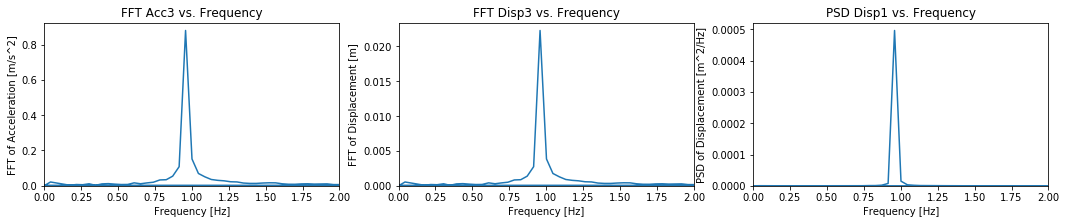

In [57]:
##Noise-corrected Acceleration spectra converted to displacement
##spectra by dividing by the frequency to the fourth power.

##Check to see if they're the same length:
#print(len(fft3))
#print(len(fft_freq3))

#for x in fft_freq3:
#    print(x**4)
    
##First attempt:   
##Iterate over the fft and freq lists to calculate new displacement spectra values.
samp_freq = 30

def calc_disp(fft, freq):
    fft = fft[1:] #Get rid of the first value, since fft_freq's first value is 0, and cannot divide by zero.
    freq = freq[1:]
    disp_spectra = []
    for x_fft, y_freq in zip(fft, freq):
        #"Normalizing" the PSD?
        new_d = float(x_fft**2/(samp_freq**4)) #Need to divide by 30**4 bc sampling freq?
        #new_d = float(x_fft/(y_freq**4)) #Using y_freq doesn't work
        #print(new_d)
        #print(y_freq)
        disp_spectra.append(new_d)
    return disp_spectra, freq

disp_spectra1, fft_nfreq1 = calc_disp(fft1, fft_freq1)
disp_spectra2, fft_nfreq2 = calc_disp(fft2, fft_freq2)
disp_spectra3, fft_nfreq3 = calc_disp(fft3, fft_freq3)



##Second attempt:

def calc_disp2(fft, freq):
    fft = fft[1:] #Get rid of the first value, since fft_freq's first value is 0, and cannot divide by zero.
    freq = freq[1:]
    disp_spectra = []
    for x_fft, y_freq in zip(fft, freq):
        omega = 2*math.pi*y_freq
        #new_d = float(x_fft/omega**2) #for FFT?
        new_d = float(x_fft/omega**4) #for PSD?
        disp_spectra.append(new_d)
    return disp_spectra, freq

#disp_spectra1, fft_nfreq1 = calc_disp2(fft1, fft_freq1)
#disp_spectra2, fft_nfreq2 = calc_disp2(fft2, fft_freq2)
#disp_spectra3, fft_nfreq3 = calc_disp2(fft3, fft_freq3)

##Attempt using PSD instead of FFT:
#disp_spectra1, fft_nfreq1 = calc_disp2(pxx1, freq1)
#disp_spectra2, fft_nfreq2 = calc_disp2(pxx2, freq2)
#disp_spectra3, fft_nfreq3 = calc_disp2(pxx3, freq3)



##Attempt #3:
f1 = 1.0
f2 = 1.0
f3 = 1.0

def calc_disp3(fft_normal_acc,freq,f):
    w = 2*np.pi*f
    omega = 1/w**2
    ret_disp = []
    for a in fft_normal_acc:
        new_d = a*omega
        ret_disp.append(new_d)
    return ret_disp, freq

disp_spectra1, fft_nfreq1 = calc_disp3(fft_normal1, fft_freq1, f1)
disp_spectra2, fft_nfreq2 = calc_disp3(fft_normal2, fft_freq2, f2)
disp_spectra3, fft_nfreq3 = calc_disp3(fft_normal3, fft_freq3, f3)

def calc_disp_psd(disp_spectra):
    disp_psd = []
    for df in disp_spectra:
        disp_psd.append(df**2)
    return disp_psd
        



##Calculating PSD from displacement FFT:
disp_psd1 = calc_disp_psd(disp_spectra1)
disp_psd2 = calc_disp_psd(disp_spectra2)
disp_psd3 = calc_disp_psd(disp_spectra3)


##Plotting the psd results:
f1 = plt.figure(figsize=(18,3))
ax1 = f1.add_subplot(131)
ax2 = f1.add_subplot(132)
ax7 = f1.add_subplot(133)

f2 = plt.figure(figsize=(18,3))
ax3 = f2.add_subplot(131)
ax4 = f2.add_subplot(132)
ax8 = f2.add_subplot(133)

f3 = plt.figure(figsize=(18,3))
ax5 = f3.add_subplot(131)
ax6 = f3.add_subplot(132)
ax9 = f3.add_subplot(133)


##Subplots for acc1
ax1.plot(fft_freq1, fft_normal1)
ax1.set_title("FFT Acc1 vs. Frequency")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel('FFT of Acceleration [m/s^2]')
ax1.set_xlim(0,2.0)
ax1.set_ylim(0,)
#ax1.xaxis.set_major_locator(plt.MultipleLocator(0.1))
#ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
#ax1.axvline(0.16, color="orange")

ax2.plot(fft_nfreq1, disp_spectra1)
ax2.set_title('FFT Disp1 vs. Frequency')
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel('FFT of Displacement [m]')
ax2.set_xlim(0,2)
ax2.set_ylim(0,)

ax7.plot(fft_nfreq1, disp_psd1)
ax7.set_title('PSD Disp1 vs. Frequency')
ax7.set_xlabel("Frequency [Hz]")
ax7.set_ylabel('PSD of Displacement [m^2/Hz]')
ax7.set_xlim(0,2.0)
ax7.set_ylim(0,)


##Subplots for acc2
ax3.plot(fft_freq2, fft_normal2)
ax3.set_title("FFT Acc2 vs. Frequency")
ax3.set_xlabel("Frequency [Hz]")
ax3.set_ylabel('FFT of Acceleration [m/s^2]')
ax3.set_xlim(0,2.0)
ax3.set_ylim(0,)
#ax3.xaxis.set_major_locator(plt.MultipleLocator(0.1))
#ax3.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
#ax3.axvline(0.25, color="orange")


ax4.plot(fft_nfreq2, disp_spectra2)
ax4.set_title('FFT Disp2 vs. Frequency')
ax4.set_xlabel("Frequency [Hz]")
ax4.set_ylabel('FFT of Displacement [m]')
ax4.set_xlim(0,2.0)
ax4.set_ylim(0,)

ax8.plot(fft_nfreq2, disp_psd2)
ax8.set_title('PSD Disp1 vs. Frequency')
ax8.set_xlabel("Frequency [Hz]")
ax8.set_ylabel('PSD of Displacement [m^2/Hz]')
ax8.set_xlim(0,2.0)
ax8.set_ylim(0,)


##Subplots for acc3
ax5.plot(fft_freq3, fft_normal3)
ax5.set_title("FFT Acc3 vs. Frequency")
ax5.set_xlabel("Frequency [Hz]")
ax5.set_ylabel('FFT of Acceleration [m/s^2]')
ax5.set_xlim(0,2.0)
ax5.set_ylim(0,)
#ax5.xaxis.set_major_locator(plt.MultipleLocator(0.1))
#ax5.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
#ax5.axvline(0.5, color="orange")

ax6.plot(fft_nfreq3, disp_spectra3)
ax6.set_title('FFT Disp3 vs. Frequency')
ax6.set_xlabel("Frequency [Hz]")
ax6.set_ylabel('FFT of Displacement [m]')
ax6.set_xlim(0,2.0)
ax6.set_ylim(0,)

ax9.plot(fft_nfreq3, disp_psd3)
ax9.set_title('PSD Disp1 vs. Frequency')
ax9.set_xlabel("Frequency [Hz]")
ax9.set_ylabel('PSD of Displacement [m^2/Hz]')
ax9.set_xlim(0,2.0)
ax9.set_ylim(0,)

plt.show()

## Calculating Wave Statistics:

In [56]:
#Print out the peak wave period: get the x-axis value at the peak y-axis value
peak_freq1 = fft_nfreq1[np.argmax(disp_spectra1)]
peak_freq2 = fft_nfreq2[np.argmax(disp_spectra2)]
peak_freq3 = fft_nfreq3[np.argmax(disp_spectra3)]

print("Calculating Peak Frequency:")
print("Expected near 0.16 Hz and got: ", peak_freq1, "Hz")
print("Expected near 0.25 Hz and got: ", peak_freq2, "Hz")
print("Expected near 0.5 Hz and got: ", peak_freq3, "Hz")


#Print out the peak wave frequency, which is 1/peak_period
peak_period1 = 1/peak_freq1
peak_period2 = 1/peak_freq2
peak_period3 = 1/peak_freq3

print("\n")
print("Calculating Peak Period:")
print("Expected near 6 secs and got: ", peak_period1, "secs")
print("Expected near 4 secs  and got: ", peak_period2, "secs")
print("Expected near 2 secs and got: ", peak_period3, "secs")

##Calculate the mean variance of the sea surface elevation, by taking the integral under the FFT curve
#We only want to integrate while fft_nfreq < 0.6:

def limit_frequency_range(fft_freq):
    ret_freq = []
    for x in fft_freq:
        if x < 0.6:
            ret_freq.append(x)
    return ret_freq

lim_freq1 = limit_frequency_range(fft_nfreq1)
lim_freq2 = limit_frequency_range(fft_nfreq2)
lim_freq3 = limit_frequency_range(fft_nfreq3)

#Need to make disp_spectra match length of newly limited frequency:
len1 = len(lim_freq1)
len2 = len(lim_freq2)
len3 = len(lim_freq3)

lim_dspectra1 = disp_spectra1[0:len1]
lim_dspectra2 = disp_spectra2[0:len2]
lim_dspectra3 = disp_spectra3[0:len3]

m0_1 = simps(y=lim_dspectra1, x=lim_freq1)
m0_2 = simps(y=lim_dspectra2, x=lim_freq2)
m0_3 = simps(y=lim_dspectra3, x=lim_freq3)

Hs1 = 4*math.sqrt(m0_1)
Hs2 = 4*math.sqrt(m0_2)
Hs3 = 4*math.sqrt(m0_3)

print("\n")
print("Calculating Significant Wave Heights:")
print("Expecting near 1m and got: ", Hs1, "[m]")
print("Expecting near 1.5m and got: ", Hs2, "[m]")
print("Expecting near 1m and got: ", Hs3, "[m]")


#Calculate the significant wave height by taking 4*sqrt(mean_variance^2)

Calculating Peak Frequency:
Expected near 0.16 Hz and got:  0.96 Hz
Expected near 0.25 Hz and got:  0.954545454545 Hz
Expected near 0.5 Hz and got:  0.957910014514 Hz


Calculating Peak Period:
Expected near 6 secs and got:  1.04166666667 secs
Expected near 4 secs  and got:  1.04761904762 secs
Expected near 2 secs and got:  1.04393939394 secs


Calculating Significant Wave Heights:
Expecting near 1m and got:  10.638452519478157 [m]
Expecting near 1.5m and got:  4.988875364271747 [m]
Expecting near 1m and got:  2.016457722625193 [m]
